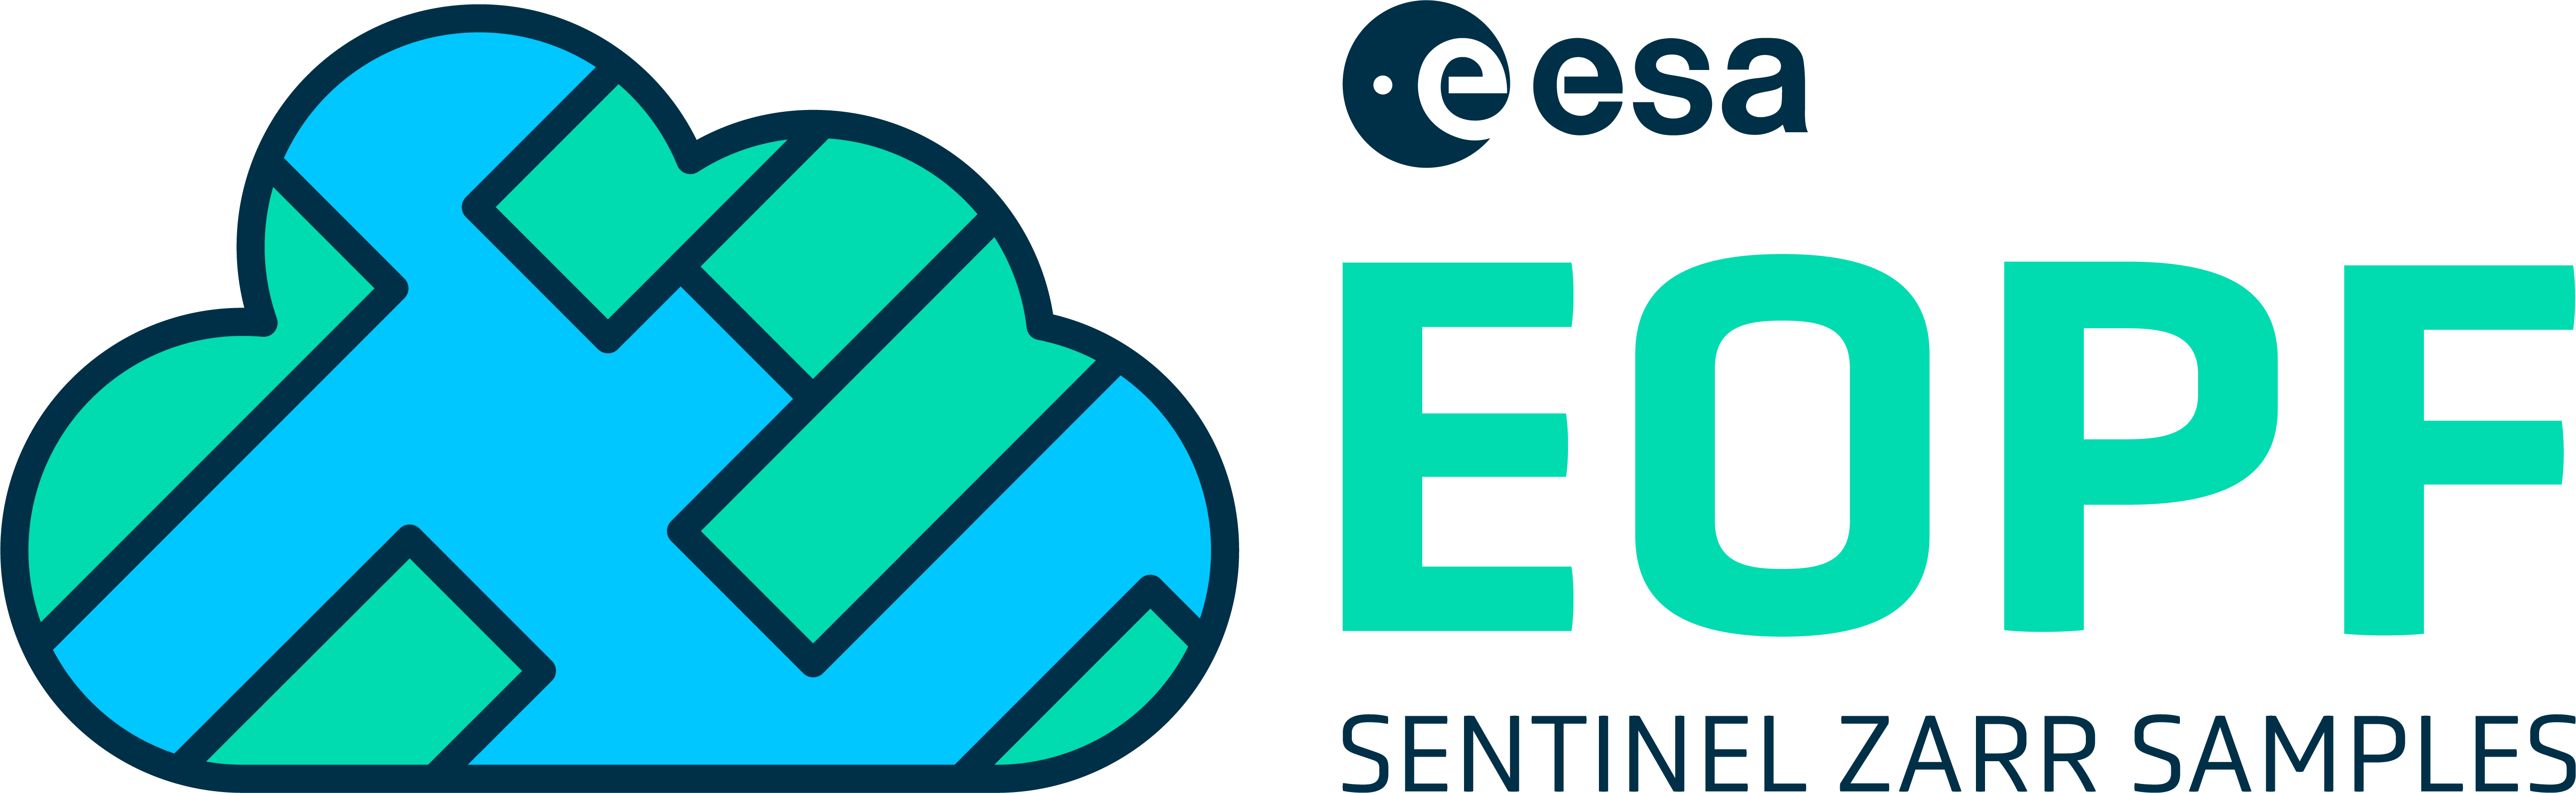

# NDVI-based approach to study Landslide areas 
Research indicates that NDVI can play a crucial role in identifying landslide zones. While an advanced workflow is possible, this notebook opts for a simple approach using the difference of NDVI and applying a threshold to the result to detect landslide occurred areas. Our analysis relies on the Sentinel-2 Level 2A collection fetched from the Copernicus Data Space Ecosystem using openEO.

# Load all the packages

In [50]:
from affine import Affine
import xarray as xr
from dask.distributed import Client, progress, LocalCluster
from typing import Dict, List, Optional
from datetime import datetime
import os
from dask.diagnostics import ProgressBar
from shapely.geometry import box
import matplotlib.pyplot as plt
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import requests
import rasterio
import numpy as np
import matplotlib.patches as mpatches
from rasterio.plot import show
import aiohttp
import asyncio
from datetime import datetime
from pathlib import Path
import geopandas as gpd
import matplotlib.colors as mcolors
from ipyleaflet import Map, Polygon
from shapely import geometry

# Create Cluster

In [47]:
cluster = LocalCluster()
client = Client(cluster)  # create a local dask cluster on the machine.
client

/home/yadagale/miniconda3/envs/openeo-dask-env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34977 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34977/status,
Dashboard: http://127.0.0.1:34977/status,Workers: 4
Total threads: 8,Total memory: 31.34 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46793,Workers: 4
Dashboard: http://127.0.0.1:34977/status,Total threads: 8
Started: Just now,Total memory: 31.34 GiB
Comm: tcp://127.0.0.1:33663,Total threads: 2
Dashboard: http://127.0.0.1:38771/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:34079,


# Load all the required functions

In [48]:
# 1. Dataset Retrieval Functions
def create_polygon_from_extent(spatial_extent: Dict[str, float]) -> str:
    """Create WKT polygon from spatial extent"""
    return f"POLYGON(({spatial_extent['west']} {spatial_extent['south']}, {spatial_extent['east']} {spatial_extent['south']}, {spatial_extent['east']} {spatial_extent['north']}, {spatial_extent['west']} {spatial_extent['north']}, {spatial_extent['west']} {spatial_extent['south']}))"

def build_query_url2(spatial_extent: Dict[str, float], temporal_extent: List[str], 
                   collection_name: str = 'SENTINEL-2', processing_level: str = 'L2A',
                   base_url: str = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products") -> str:
    """Build OData query URL"""
    polygon = create_polygon_from_extent(spatial_extent)
    start_iso = f"{temporal_extent[0]}T00:00:00.000Z"
    end_iso = f"{temporal_extent[1]}T00:00:00.000Z"
    
    filter_params = [
        f"Collection/Name eq '{collection_name}'",
        f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}')",
        f"contains(Name,'{processing_level}')",
        f"ContentDate/Start gt {start_iso}",
        f"ContentDate/Start lt {end_iso}"
    ]
    return f"{base_url}?$count=true&$filter={' and '.join(filter_params)}"

def build_query_url(spatial_extent: Dict[str, float], temporal_extent: List[str], 
                   collection_name: str = 'SENTINEL-2', processing_levels: List[str] = ['L2A'],
                   base_url: str = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products") -> str:
    """Build OData query URL with support for multiple processing levels"""
    polygon = create_polygon_from_extent(spatial_extent)
    start_iso = f"{temporal_extent[0]}T00:00:00.000Z"
    end_iso = f"{temporal_extent[1]}T00:00:00.000Z"
    
    # Create the processing level filter without nested f-strings
    level_conditions = [f"contains(Name,'{level}')" for level in processing_levels]
    processing_filter = f"({' or '.join(level_conditions)})"
    
    filter_params = [
        f"Collection/Name eq '{collection_name}'",
        f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}')",
        processing_filter,
        f"ContentDate/Start gt {start_iso}",
        f"ContentDate/Start lt {end_iso}"
    ]
    return f"{base_url}?$count=true&$filter={' and '.join(filter_params)}"


def get_all_results2(initial_url: str) -> List[Dict]:
    """Paginate through all results"""
    results = []
    current_url = initial_url
    while current_url:
        response = requests.get(current_url)
        data = response.json()
        results.extend([{"Name": item["Name"], "S3Path": item["S3Path"]} for item in data.get('value', [])])
        current_url = data.get('@odata.nextLink')
    return results

# Using parallel processing to get_all_results
def fetch_page(url):
    """Fetch a single page of results"""
    response = requests.get(url)
    data = response.json()
    results = [{"Name": item.get('Name'), "S3Path": item.get('S3Path')} 
               for item in data.get('value', [])]
    next_url = data.get('@odata.nextLink')
    return results, next_url

def get_all_results_parallel3(initial_url, max_workers=10):
    """Get all results using parallel requests with bounded concurrency"""
    all_results = []
    urls_to_process = [initial_url]
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        while urls_to_process:
            # Process up to max_workers URLs in parallel
            futures = [executor.submit(fetch_page, url) for url in urls_to_process[:max_workers]]
            urls_to_process = []
            
            # Collect results and new URLs
            for future in futures:
                page_results, next_url = future.result()
                all_results.extend(page_results)
                if next_url:
                    urls_to_process.append(next_url)
    
    return all_results


async def get_all_results_async(initial_url, max_concurrent=10):
    """Get all results using async/await pattern"""
    all_results = []
    
    async with aiohttp.ClientSession() as session:
        semaphore = asyncio.Semaphore(max_concurrent)  # Limit concurrent requests
        
        async def fetch_page(url):
            async with semaphore:
                async with session.get(url) as response:
                    data = await response.json()
                    results = [{"Name": item.get('Name'), "S3Path": item.get('S3Path')} 
                              for item in data.get('value', [])]
                    next_url = data.get('@odata.nextLink')
                    return results, next_url
        
        # Start with initial URL
        urls_to_process = [initial_url]
        while urls_to_process:
            # Process URLs concurrently
            tasks = [fetch_page(url) for url in urls_to_process]
            results = await asyncio.gather(*tasks)
            
            # Reset URLs and collect results
            urls_to_process = []
            for page_results, next_url in results:
                all_results.extend(page_results)
                if next_url:
                    urls_to_process.append(next_url)
    
    return all_results

# 2. Data Loading and Processing
def load_zarr_datasets(datasets: List[Dict], bands: List[str]) -> xr.Dataset:
    """Load multiple Zarr datasets into an xarray Dataset"""
    def preprocess(ds, url):
        ds = ds[bands]
        time = np.datetime64(ds.attrs["datetime"])
        return ds.expand_dims(time=[time]).assign_coords(time=("time", [time]))
    
    datasets = [xr.open_dataset(d["S3Path"], engine="zarr", chunks={}) for d in datasets]
    return xr.concat([preprocess(ds, ds.encoding["source"]) for ds in datasets], dim="time")

def process_dataset_urls(datasets: List[Dict], base_url: str) -> List[Dict]:
    """Convert dataset names to custom Zarr store URLs"""
    processed = []
    for ds in datasets:
        # Remove .SAFE extension from name
        clean_name = ds["Name"].replace(".SAFE", "")
        # Build new S3Path URL
        new_url = base_url.format(clean_name)
        processed.append({
            "Name": ds["Name"],
            "S3Path": new_url
        })
    return processed

# 3. NDVI Calculation
def calculate_ndvi(ds: xr.Dataset) -> xr.DataArray:
    """Calculate NDVI from dataset with B04 and B08"""
    red = ds["B04"]
    nir = ds["B08"]
    return (nir - red) / (nir + red)

# 4. Parameters (Ischia Example)
spatial_extent = {
    "west": 13.882567, "south": 40.715063,
    "east": 13.928594, "north": 40.747050
}


# Retrieve Pre/Post Event Datasets

In [4]:
pre_url = build_query_url(spatial_extent, ["2022-08-25", "2022-11-25"], processing_levels=["L2A", "L2B"])
post_url = build_query_url(spatial_extent, ["2022-11-26", "2022-12-25"], processing_levels=["L2A", "L2B"])

## Approach 1: Get all results using async/aiohttp

In [5]:
pre_datasets_async = await get_all_results_async(pre_url)
post_dataset_async = await get_all_results_async(post_url)
print(len(pre_datasets_async))
print(len(post_dataset_async))

132
24


## Approach 2: Get all results with parellel processing

In [90]:
pre_datasets_parallel = get_all_results_parallel3(pre_url)
post_datasets_parallel = get_all_results_parallel3(post_url)
print(len(pre_datasets_parallel))
print(len(post_datasets_parallel))

132
24


## Approach 3: Get all results without async/aiohttp or parellel processing

In [7]:
pre_datasets = get_all_results2(pre_url)
post_datasets = get_all_results2(post_url)
print(len(pre_datasets))
print(len(post_datasets))

132
24


In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm  # Optional for progress bar
def check_dataset_availability(url):
    """
    Try opening the dataset using xr.open_datatree.
    Returns True if available, False otherwise.
    """
    try:
        xr.open_dataset(url, engine="zarr", chunks={})
        return True
    except FileNotFoundError:
        return False
# 2. Modified dataset processing with availability checks
def get_valid_datasets(datasets: List[Dict], base_url: str) -> List[Dict]:
    """Process URLs and check availability in parallel"""
    # Process URLs first
    processed = process_dataset_urls(datasets, base_url)
    
    # Check availability in parallel
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {
            executor.submit(check_dataset_availability, ds["S3Path"]): ds
            for ds in processed
        }
        
        valid_datasets = []
        for future in tqdm(as_completed(futures), total=len(processed), desc="Checking datasets"):
            ds = futures[future]
            if future.result():
                valid_datasets.append(ds)
                
    print(f"Found {len(valid_datasets)}/{len(processed)} valid datasets")
    return valid_datasets

# Process pre/post datasets to create new URL's

In [10]:
pre_datasets# Base URL template from objectstore.eodc.eu
OBJECTSTORE_BASE = "https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/{}.zarr"

# Process pre/post datasets
pre_datasets_processed = process_dataset_urls(pre_datasets, OBJECTSTORE_BASE)
post_datasets_processed = process_dataset_urls(post_datasets, OBJECTSTORE_BASE)

# Process and validate datasets

In [42]:
pre_datasets = get_valid_datasets(pre_datasets_processed, OBJECTSTORE_BASE)
post_datasets = get_valid_datasets(post_datasets_processed, OBJECTSTORE_BASE)

Checking datasets: 100%|██████████| 132/132 [00:01<00:00, 108.67it/s]


Found 110/132 valid datasets


Checking datasets: 100%|██████████| 24/24 [00:00<00:00, 109.31it/s]

Found 22/24 valid datasets


In [43]:
pre_datasets = [d['S3Path'] for d in pre_datasets]
post_datasets = [d['S3Path'] for d in post_datasets]

# By default, xarray.open_dataset automatically applies scale_factor and add_offset, converting raw integer data to physical reflectance values (float).

In [99]:
# Default behavior (with scaling)
ds_scaled = xr.open_dataset(pre_datasets[0], engine="zarr", 
                          group="/measurements/reflectance/r10m")
ds_scaled

<xarray.Dataset> Size: 4GB
Dimensions:  (y: 10980, x: 10980)
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225
Data variables:
    b02      (y, x) float64 964MB ...
    b03      (y, x) float64 964MB ...
    b04      (y, x) float64 964MB ...
    b08      (y, x) float64 964MB ...

# If you set mask_and_scale=False, the raw uint16 sensor values are loaded without scaling.

In [100]:
# Disable scaling
ds_raw = xr.open_dataset(pre_datasets[0], engine="zarr",
                        group="/measurements/reflectance/r10m",
                        mask_and_scale=False)
ds_raw

<xarray.Dataset> Size: 965MB
Dimensions:  (y: 10980, x: 10980)
Coordinates:
  * x        (x) int64 88kB 300005 300015 300025 300035 ... 409775 409785 409795
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225
Data variables:
    b02      (y, x) uint16 241MB ...
    b03      (y, x) uint16 241MB ...
    b04      (y, x) uint16 241MB ...
    b08      (y, x) uint16 241MB ...

In [14]:
print(len(pre_datasets))
print(len(post_datasets))

110
22


**Lets create full timeseries dataset for list of datasets we will use.** 

To create full timeseries, we need to extract the time information. For the moment i do not know how to get time information from metadata, but only from the file name we make a function to get that information from the file name

In [15]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

In [16]:
%%time
r10m_pre = xr.open_mfdataset(
    pre_datasets[:],
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False
)
r10m_pre

CPU times: user 5.52 s, sys: 480 ms, total: 6 s
Wall time: 15.2 s


<xarray.Dataset> Size: 405GB
Dimensions:  (time: 110, y: 10980, x: 20976)
Coordinates:
  * x        (x) int64 168kB 300005 300015 300025 ... 509735 509745 509755
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225
  * time     (time) datetime64[ns] 880B 2022-10-07T10:00:29 ... 2022-09-12T09...
Data variables:
    b02      (time, y, x) float32 101GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (time, y, x) float32 101GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (time, y, x) float32 101GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (time, y, x) float32 101GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [17]:
pre_r10m_by_day = r10m_pre.groupby(r10m_pre.time.dt.floor('D')).max(skipna=True)
pre_r10m_by_day

<xarray.Dataset> Size: 133GB
Dimensions:  (floor: 36, y: 10980, x: 20976)
Coordinates:
  * x        (x) int64 168kB 300005 300015 300025 ... 509735 509745 509755
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225
  * floor    (floor) datetime64[ns] 288B 2022-08-25 2022-08-28 ... 2022-11-21
Data variables:
    b02      (floor, y, x) float32 33GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (floor, y, x) float32 33GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (floor, y, x) float32 33GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (floor, y, x) float32 33GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [18]:
%%time
r10m_post = xr.open_mfdataset(
    post_datasets[:],
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
)
r10m_post

CPU times: user 865 ms, sys: 60.9 ms, total: 926 ms
Wall time: 3.12 s


<xarray.Dataset> Size: 81GB
Dimensions:  (time: 22, y: 10980, x: 20976)
Coordinates:
  * x        (x) int64 168kB 300005 300015 300025 ... 509735 509745 509755
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225
  * time     (time) datetime64[ns] 176B 2022-11-26T10:02:49 ... 2022-11-26T10...
Data variables:
    b02      (time, y, x) float32 20GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (time, y, x) float32 20GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (time, y, x) float32 20GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (time, y, x) float32 20GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

In [19]:
post_r10m_by_day = r10m_post.groupby(r10m_post.time.dt.floor('D')).max(skipna=True)
post_r10m_by_day

<xarray.Dataset> Size: 44GB
Dimensions:  (floor: 12, y: 10980, x: 20976)
Coordinates:
  * x        (x) int64 168kB 300005 300015 300025 ... 509735 509745 509755
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225
  * floor    (floor) datetime64[ns] 96B 2022-11-26 2022-11-28 ... 2022-12-23
Data variables:
    b02      (floor, y, x) float32 11GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03      (floor, y, x) float32 11GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04      (floor, y, x) float32 11GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b08      (floor, y, x) float32 11GB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

# Apply scaling factor and add offset and calculate NDVI

**Using open_mfdataset does not apply scaling factore and add offset, but its works with open_datatree**

In [49]:
def calculate_ndvi(ds: xr.Dataset) -> xr.DataArray:
    """Calculate NDVI from dataset with B04 and B08"""
    red = (
        ds["b04"] * ds["b04"].attrs["_eopf_attrs"]["scale_factor"]
        + ds["b04"].attrs["_eopf_attrs"]["add_offset"]
    )

    nir = (
        ds["b08"] * ds["b08"].attrs["_eopf_attrs"]["scale_factor"]
        + ds["b08"].attrs["_eopf_attrs"]["add_offset"]
    )
    return (nir - red) / (nir + red)


In [21]:
pre_r10m_by_day = pre_r10m_by_day.rename({'floor': 'time'})
pre_ndvi = calculate_ndvi(pre_r10m_by_day).mean(dim="time")

In [22]:
pre_ndvi

<xarray.DataArray (y: 10980, x: 20976)> Size: 921MB
dask.array<mean_agg-aggregate, shape=(10980, 20976), dtype=float32, chunksize=(1830, 2676), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 168kB 300005 300015 300025 ... 509735 509745 509755
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225

In [23]:
post_r10m_by_day = post_r10m_by_day.rename({'floor': 'time'})
post_ndvi = calculate_ndvi(post_r10m_by_day).mean(dim="time")

In [24]:
post_ndvi

<xarray.DataArray (y: 10980, x: 20976)> Size: 921MB
dask.array<mean_agg-aggregate, shape=(10980, 20976), dtype=float32, chunksize=(1830, 2676), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int64 168kB 300005 300015 300025 ... 509735 509745 509755
  * y        (y) int64 88kB 4600015 4600005 4599995 ... 4490245 4490235 4490225

In [25]:
ndvi_diff = post_ndvi - pre_ndvi

# Save and Visualize

In [26]:
ndvi_diff.rio.to_raster("NDVIDiff_landslide6.tiff")

/home/yadagale/miniconda3/envs/openeo-dask-env/lib/python3.11/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 55.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/yadagale/miniconda3/envs/openeo-dask-env/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/yadagale/miniconda3/envs/openeo-dask-env/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [38]:
with rasterio.open("NDVIDiff_landslide6.tiff") as src:
    profile = src.profile
    profile.update(crs='EPSG:32633')
    
    with rasterio.open("NDVIDiff_landslide6_with_crs.tiff", 'w', **profile) as dst:
        dst.write(src.read())

# Overlay AOI bounding box on top of the TIFF image

In [39]:
import rasterio
from rasterio.warp import transform_bounds
from matplotlib.patches import Rectangle
from rasterio.crs import CRS

# Open your raster and get its CRS
img = rasterio.open("NDVIDiff_landslide6_with_crs.tiff")
raster_transform = img.transform
raster_crs = img.crs
print(f"Transform: {raster_transform}")
print(f"CRS : {raster_crs}")

Transform: | 10.00, 0.00, 300000.00|
| 0.00,-10.00, 4600020.00|
| 0.00, 0.00, 1.00|
CRS : EPSG:32633


### Project bbox to raster CRS

In [40]:
# Your bounding box in lon/lat (EPSG:4326)
bbox = [13.882567409197492, 40.7150627793427, 13.928593792166282, 40.747050251559216]
bbox_proj = transform_bounds("EPSG:4326", "EPSG:32632", *bbox)
bbox_proj

(912271.660759628, 4518606.078548507, 916359.3323759218, 4522376.551388217)

### Plot tiff and bounding box together

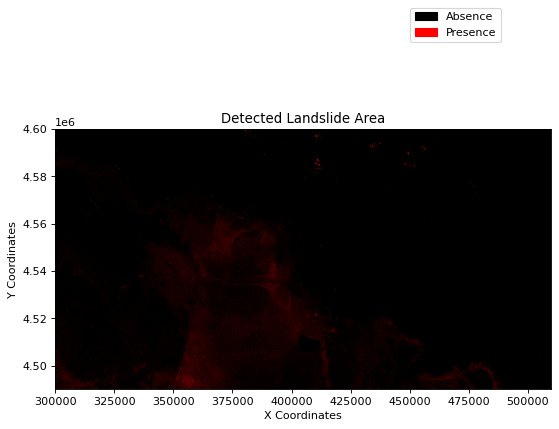

In [41]:
img = rasterio.open("NDVIDiff_landslide6_with_crs.tiff")
value = img.read(1)
cmap = matplotlib.colors.ListedColormap(["black", "red"])
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

show(((value < -0.48) & (value > -1)), 
     cmap=cmap, transform=img.transform, ax=ax)
ax.set_title("Detected Landslide Area")
ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")

# Draw the projected bounding box
minx, miny, maxx, maxy = bbox_proj
rect = Rectangle(
    (minx, miny),
    maxx - minx,
    maxy - miny,
    linewidth=2,
    edgecolor='green',
    facecolor='none'
)
ax.add_patch(rect)

patches = [mpatches.Patch(color=color, label=label) 
          for color, label in zip(["black", "red"], ["Absence", "Presence"])]
fig.legend(handles=patches, bbox_to_anchor=(0.83, 1.03), loc=1)
plt.show()

# Subset spatially

It is always good practice to select data over the area of interest, as this can significantly reduce memory usage when computing NDVI or applying any processing.

In [51]:
epsg = 32632

bbox = [13.882567409197492, 40.7150627793427, 13.928593792166282, 40.747050251559216]

bbox_coords = [13.882567409197492, 40.7150627793427, 13.928593792166282, 40.747050251559216]
center = ((bbox[1] + bbox[3]) / 2.0, (bbox[0] + bbox[2]) / 2.0)
m = Map(center=center, zoom=11)
# Create polygon from lists of points
polygon = Polygon(
    locations=[
        (bbox[1], bbox[0]),
        (bbox[3], bbox[0]),
        (bbox[3], bbox[2]),
        (bbox[1], bbox[2]),
    ],
    color="green",
    fill_color="green",
)

# Add the polygon to the map
m.add(polygon)
m

Map(center=[40.73105651545096, 13.905580600681887], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [52]:
bbox_polygon = geometry.box(*bbox)

polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
bbox_reproj

(912271.660759628, 4518606.078548507, 916359.3323759218, 4522376.551388217)

In [54]:
# 1. Make sure your polygon is in the same CRS as your data
polygon_reproj = polygon.to_crs(f"epsg:{epsg}")

# 2. Clip using the polygon geometry
post_r10m_by_day_clipped = ndvi_diff.rio.write_crs(epsg).rio.clip(
    polygon_reproj.geometry,
    polygon_reproj.crs
)

NoDataInBounds: No data found in bounds.